# (Optional) Load Data from Kaggle into Google Colab

In [29]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T123404Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D33ff7d3bb9089ac1acfd059a69120154571a72e19707d0e119e2adabf0124c941534c4b866cd2bce6d231cc31aeb93daf7cdc71224f78f7b418c861af7aec4f5b699405b613361cd61b2e94951f135763b79cda86486bec220e2652c573ce7a4ca38eaf354cb836ba04f7555f003c32cf5a943954467d03ae80c17d75c399aa9d0f3360a77ef3bede921135e634fba22f9e64d93a50255670f2a4d266a3adc37fe7de1c2adc45d30a39107a991303512d704e39e7b1f3eabc4867efab49078fa19bdf29fc51615245ab41b1186cf763bca93503c1cba263d93caf60deabe928c096631a8eb85d0d6b678836213955f91dc3555d0fdef6ee909edd10148c25528'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


# Scratch Model

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,  Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Rescaling, RandomTranslation, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import f1_score, confusion_matrix, classification_report

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


## Preprocessing and Data Augmentation

In [31]:
base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'
batch_size = 64
epochs = 70

In [32]:
# Documentation: https://keras.io/api/data_loading/image/
train_ds, validation_ds = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=420,
    subset="both",
    validation_split=0.15,
    image_size=(100, 100))


class_names = train_ds.class_names

print(train_ds.class_names)

Found 9108 files belonging to 5 classes.
Using 7742 files for training.
Using 1366 files for validation.
['angry', 'fear', 'happy', 'sad', 'surprise']


In [33]:
from sklearn.utils import class_weight


normalization_layer = Rescaling(1./255)

# Documentation: https://keras.io/api/layers/preprocessing_layers/image_augmentation/
data_augmentation = Sequential([
    RandomContrast(0.002),
    RandomBrightness(0.002),
    RandomFlip("horizontal"),
    RandomZoom(0.25, 0.25),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    RandomRotation(0.1)
])

train_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
train_labels = np.argmax(train_labels, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

image_batch, label_batch = next(iter(train_ds.unbatch().batch(5)))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))

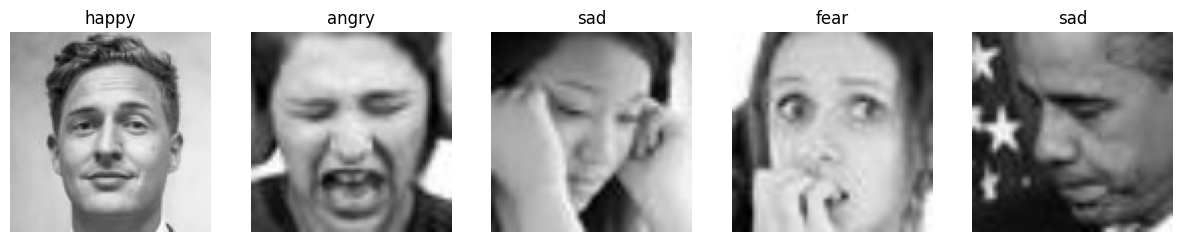

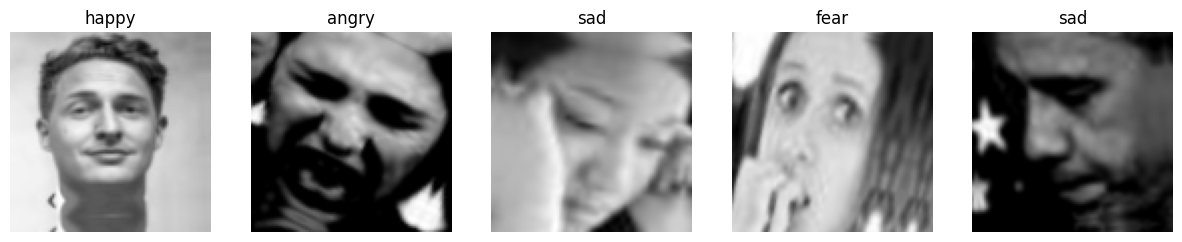

In [34]:
def plot_images(images, titles, rows=1, cols=5, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Normalize images for visualization
normalized_images = normalization_layer(image_batch)

# Apply augmentation to the same images
augmented_images = data_augmentation(normalized_images, training=True)

# Plot original images
plot_images(normalized_images, titles=[class_names[label.numpy().argmax()] for label in label_batch], rows=2, cols=5, figsize=(15, 6))

# Plot augmented images
plot_images(augmented_images, titles=[class_names[label.numpy().argmax()] for label in label_batch], rows=2, cols=5, figsize=(15, 6))


## Model definition and training

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 23, 23, 128)       0         
 ng2D)                                                

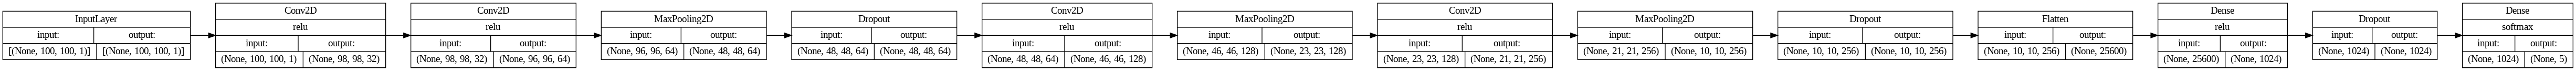

In [35]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(100,100,1)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),


    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.25),
    Dense(5, activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, to_file='scratch_model.png', show_layer_activations=True, rankdir="LR", show_layer_names=False, show_shapes=True)

In [36]:
# Define the optimizer
initial_learning_rate = 0.00015
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)


# Compile the model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=13, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

# Training des Modells
history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, batch_size=batch_size,class_weight=class_weights, callbacks=[reduce_lr, early_stopping])


Epoch 1/70
121/121 [==============================] - 11s 74ms/step - loss: 1.6108 - accuracy: 0.2121 - val_loss: 1.5970 - val_accuracy: 0.2350 - lr: 1.4999e-04
Epoch 2/70
121/121 [==============================] - 10s 80ms/step - loss: 1.6025 - accuracy: 0.2330 - val_loss: 1.6025 - val_accuracy: 0.2562 - lr: 1.4999e-04
Epoch 3/70
121/121 [==============================] - 10s 80ms/step - loss: 1.5858 - accuracy: 0.2582 - val_loss: 1.5818 - val_accuracy: 0.3060 - lr: 1.4998e-04
Epoch 4/70
121/121 [==============================] - 10s 80ms/step - loss: 1.5663 - accuracy: 0.2831 - val_loss: 1.5289 - val_accuracy: 0.3426 - lr: 1.4997e-04
Epoch 5/70
121/121 [==============================] - 10s 80ms/step - loss: 1.5394 - accuracy: 0.3020 - val_loss: 1.4758 - val_accuracy: 0.3865 - lr: 1.4996e-04
Epoch 6/70
121/121 [==============================] - 10s 80ms/step - loss: 1.5028 - accuracy: 0.3400 - val_loss: 1.4334 - val_accuracy: 0.3997 - lr: 1.4996e-04
Epoch 7/70
121/121 [==============

## Model evaluation

In [40]:
# Vorhersagen für die Validierungsdaten
y_val_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_val_pred = model.predict(validation_ds)

# Umwandeln der Vorhersagen in One-Hot-Format
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

# F1-Score berechnen
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

22/22 [==============================] - 0s 4ms/step
F1-Score:  0.71851365404273


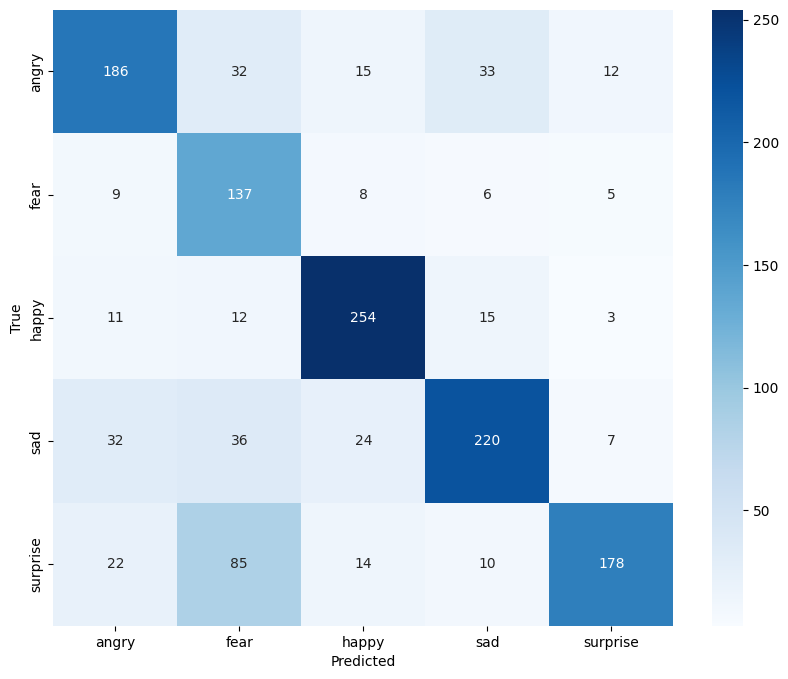

              precision    recall  f1-score   support

       angry       0.72      0.67      0.69       278
        fear       0.45      0.83      0.59       165
       happy       0.81      0.86      0.83       295
         sad       0.77      0.69      0.73       319
    surprise       0.87      0.58      0.69       309

    accuracy                           0.71      1366
   macro avg       0.72      0.73      0.71      1366
weighted avg       0.75      0.71      0.72      1366



In [41]:
# Confusion Matrix und Classification Report
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))


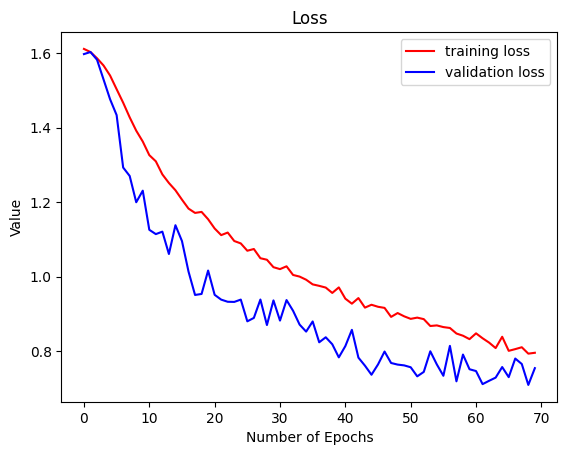

In [42]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['loss'], color='r', label="training loss")
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()